# 1.D: Bayesian analysis of the radioactivity experiment (1 parameter)

**Question:** What is the activity of this radioactive source? 

Since the outcome of the experiment is unpredictable, the answer to the question can only be probabilistic, not definitive. Instead of a single value, a range of possible values must be given (an *interval*) along with a probability qualifier.

The method you use depends on your precise definition of probability. This tutorial shows the approach for *Bayesian* probability.

In [1]:
# Import modules needed for this tutorial

from trisep.RadioactiveSource import RadioactiveSource
from trisep.RadiationCounter import RadiationCounter, SimulatedRadiationCounter
import numpy as np
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background') # only include this if you use a dark background for Jupyter Lab

The Bayesian approach produces a "credible interval" instead of a "confidence interval". 

- The activity, $A$, is considered to be a random variable. Its probability distribution (of our degree of belief) is calculated by specifying:
  - the distribution of our prior degree of belief, and 
  - the likelihood of observing the data

- With that probability distribution, we can find a 90% credible interval, having endpoints $a_{\rm low}$ and $a_{\rm high}$, such that:
$P(a_{\rm low} \le A \le a_{\rm high}|{\rm data})=0.9$.

**Question**: How does this differ from the interpretation of the "confidence interval"?

To calculate the Bayesian probability $P(a_{\rm low} \le A \le a_{\rm high}|{\rm data})$ (referred to as the posterior probability), we use
Bayes rule (page 18 of reference notes) written in general form as:

$$ P(A|B) = \frac{P(B|A)P(A)}{P(B)} $$

To apply this general equation to this problem, we identify the symbols as follows:
 - $A \rightarrow a_{\rm low} \le A \le a_{\rm high}$
 - $B \rightarrow$ data

To perform the calculation, we can break up all possible activities into $m$
sub-intervals. Since those are mutually exclusive, the total probability is just the sum of the probabilities, for example
 - $P(a_{\rm low} \le A \le a_{\rm high}|{\rm data}) = \sum_{i=0}^{m-1} P(a_{i} \le A \le a_{i+1}|{\rm data}) \,\delta(i)$
   - where $\delta(i)$ = 1 if $[a_i,a_{i+1}]$ is inside $[a_{\rm low}, a_{\rm high}]$, and 0 otherwise

For each sub-interval we can use Bayes theorem:

$$P(a_{i} \le A \le a_{i+1}|{\rm data}) = \frac{P({\rm data}|a_{i} \le A \le a_{i+1})\,P(a_{i} \le A \le a_{i+1})}{P(\rm data)}$$
 - $P({\rm data}|a_{i} \le A \le a_{i+1})$ is the **likelihood**
 - $P(a_{i} \le A \le a_{i+1})$ is the **prior** degree of belief (before seeing data)
 - $\eqalign{P({\rm data})&=\sum_{i=0}^{m-1} P({\rm data},a_{i} \le A \le a_{i+1}) \\&=\sum_{i=0}^{m-1} P({\rm data}|a_{i} \le A \le a_{i+1}) \,P(a_{i} \le A \le a_{i+1})}$

## Special case: Uniform prior

For the special case where the prior degree of beliefs for the sub-intervals of $A$ are equal (ie. a uniform distribution), then
$$P(a_{i} \le A \le a_{i+1}) = \frac{1}{m}$$
and so,
$$P(a_{i} \le A \le a_{i+1}|{\rm data}) = \frac{P({\rm data}|a_{i} \le A \le a_{i+1})}{\sum_{i=0}^{m-1} P({\rm data},a_{i} \le A \le a_{i+1})}$$
This form suggests that the likelihood can be treated as a probability distribution, that only needs to be normalized. Note that this is only the case for this special case of a uniform prior. 

In general, do not treat likelihood as a probability distribution of the parameter, and do not integrate the likelihood function over the parameter. The likelihood needs to be multiplied by the prior to form the posterior probability distribution for the parameter.

In [2]:
# Do Bayesian calculation, assuming the prior degree of belief for A is uniform from 0 to 2.
# Break up that interval into 1000 sub-intervals
# Calculate the degree of belief that the true value is in the rigorous frequentist interval [0.26,1.18]

observed = 6

sim_source = RadioactiveSource(2.) # specifies the activity of simulated source
sim_detector = SimulatedRadiationCounter() # this is NOT the lab detector, just a simulation of a detector

sim_detector.insert_calibration_source(sim_source)
sim_detector.set_counting_time(10)

a_prior_range = [0., 2.]
m = 1000
a_range = np.linspace(a_prior_range[0],a_prior_range[1],num=m+1)
prior_p = 1./m

a_low = 0.26
a_high = 1.18

p_data = 0.
p_numerator = 0.
cumulative = []
for i in range(m):
    # use midpoint value for activity
    a = (a_range[i]+a_range[i+1])/2.
    sim_source.set_activity(a)
    likelihood = sim_detector.get_likelihood(observed)
    p_data += likelihood * prior_p
    p_numerator += likelihood * prior_p * (a_low <= a <= a_high)
    cumulative.append(p_data)


p_dob = p_numerator/p_data

print('Posterior degree of belief that activity is in the range [',a_low,',',a_high,'] is',p_dob)

# The posterior probability calculated assuming a uniform prior is similar to the confidence interval (90%)

cumulative = np.array(cumulative)/p_data
for i in range(1,m):
    # use midpoint value for activity
    a = (a_range[i]+a_range[i+1])/2.
    if cumulative[i-1] < 0.05 < cumulative[i]:
        bayes_low = a
    elif cumulative[i-1]  < 0.95 < cumulative[i]:
        bayes_high = a

print('90% credible interval: [',round(bayes_low,3),',',round(bayes_high,3),']')

Simulated detector built. Counting time = 10.0 Efficiency = 1.0 Background rate= 0.0 (Hz)
Posterior degree of belief that activity is in the range [ 0.26 , 1.18 ] is 0.9318880253969956
90% credible interval: [ 0.329 , 1.183 ]


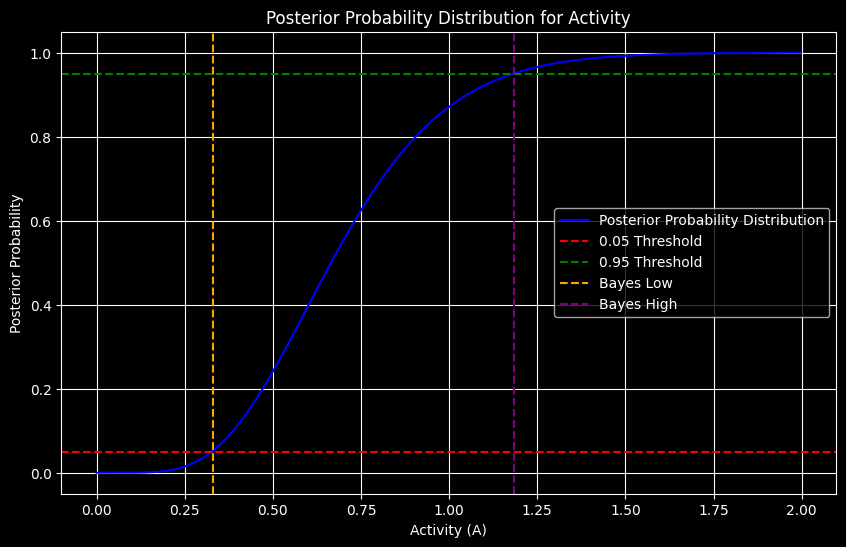

In [3]:
# Plot the posterior cumulative probability distribution
plt.figure(figsize=(10, 6))
plt.plot(a_range[:-1], cumulative, label='Posterior Probability Distribution', color='blue')
plt.axhline(0.05, color='red', linestyle='--', label='0.05 Threshold')
plt.axhline(0.95, color='green', linestyle='--', label='0.95 Threshold')
plt.axvline(bayes_low, color='orange', linestyle='--', label='Bayes Low')
plt.axvline(bayes_high, color='purple', linestyle='--', label='Bayes High')
plt.title('Posterior Probability Distribution for Activity')
plt.xlabel('Activity (A)')
plt.ylabel('Posterior Probability')
plt.legend()
plt.grid()
plt.show()

### Repeat the calculations for a prior distribution with $P(a) \propto a$ over the same range.

How does that change the posterior distribution and the credible interval?

In [4]:
# Do Bayesian calculation, assuming the prior degree of belief for A is proportional to A from 0 to 2.
# Break up that interval into 1000 sub-intervals
observed = 6
sim_source = RadioactiveSource(2.) # specifies the activity of simulated source
sim_detector = SimulatedRadiationCounter() # this is NOT the lab detector, just a simulation of a detector
sim_detector.insert_calibration_source(sim_source)
sim_detector.set_counting_time(10)
a_prior_range = [0., 2.]
m = 1000
a_range = np.linspace(a_prior_range[0], a_prior_range[1], num=m+1)
prior_p = (a_range[1:] + a_range[:-1]) / (2 * a_range[-1])  # P(a) proportional to a
a_low = 0.26
a_high = 1.18
p_data = 0.
p_numerator = 0.
cumulative = []
for i in range(m):
    # use midpoint value for activity
    a = (a_range[i] + a_range[i + 1]) / 2.
    sim_source.set_activity(a)
    likelihood = sim_detector.get_likelihood(observed)
    p_data += likelihood * prior_p[i]
    p_numerator += likelihood * prior_p[i] * (a_low <= a <= a_high)
    cumulative.append(p_data)
p_dob = p_numerator / p_data
print('Posterior degree of belief that activity is in the range [', a_low, ',', a_high, '] is', p_dob)
# The posterior probability calculated assuming a prior proportional to A is different from the confidence interval (90%)
cumulative = np.array(cumulative) / p_data
for i in range(1, m):
    # use midpoint value for activity
    a = (a_range[i] + a_range[i + 1]) / 2.
    if cumulative[i - 1] < 0.05 < cumulative[i]:
        bayes_low = a
    elif cumulative[i - 1] < 0.95 < cumulative[i]:
        bayes_high = a
print('90% credible interval: [', round(bayes_low, 3), ',', round(bayes_high, 3), ']')

Simulated detector built. Counting time = 10.0 Efficiency = 1.0 Background rate= 0.0 (Hz)
Posterior degree of belief that activity is in the range [ 0.26 , 1.18 ] is 0.8967528516952552
90% credible interval: [ 0.399 , 1.313 ]
